Linear Method

## Commentaires et communication entre nous:

J'ai changé l'évalution des erreurs, j'avais calculé des MSE en général, mais sur kaggle on sera évalués sur la RMSE, ça change presque rien mais comme ça c'est pareil.

In [4]:
data <- read.csv(file.path("..", "data", "training_data.csv"))

In [5]:
set.seed(199)
idx.train <- sample(nrow(data), nrow(data)/2)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]

In [43]:
#Linear regression on the data set with the test and training errors

set.seed(199)
idx.train <- sample(nrow(data), nrow(data)/2)
data.train <- data[idx.train,]
data.test <- data[-idx.train,]

lm.fit <- lm(VALENCE.PLEASANTNESS ~ ., data.train)
summary(lm.fit)
RSS = sum((data.test$VALENCE.PLEASANTNESS - predict(lm.fit, data.test))^2)
RSS
RMSE=sqrt(mean((data.test$VALENCE.PLEASANTNESS - predict(lm.fit, data.test))^2))
print(RMSE)
#quality.of.fit <- function(fit, data) {
#    RSS <- sum((data$VALENCE.PLEASANTNESS - predict(fit, data))^2)
#    TSS <- sum((data$VALENCE.PLEASANTNESS - mean(data$VALENCE.PLEASANTNESS))^2)
#    cat(c("Residual standard error: ", sqrt(1/(nrow(data) - length(coefficients(fit))) * RSS), " R^2 = ", 1 - RSS/TSS, "\n")) }
#quality.of.fit(lm.fit, data.train)
#quality.of.fit(lm.fit, data.test)

#--> test RSS very high
#-->RMSE is 64134 as a baseline for comparison


Call:
lm(formula = VALENCE.PLEASANTNESS ~ ., data = data.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-25.239  -1.696   0.000   1.326  25.239 

Coefficients: (4618 not defined because of singularities)
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             1.110e+08  4.687e+07   2.369 0.019742 *  
Intensitylow            5.605e+00  2.219e+00   2.525 0.013129 *  
SWEETORSOURTRUE         3.113e+01  3.500e+00   8.894 2.61e-14 ***
complexity.from.pubmed -8.820e+01  3.263e+01  -2.703 0.008067 ** 
MW                     -2.792e+04  1.250e+04  -2.232 0.027816 *  
AMW                    -4.260e+05  1.752e+05  -2.432 0.016791 *  
Sv                      7.588e+06  3.168e+06   2.395 0.018480 *  
Se                      7.679e+06  3.172e+06   2.421 0.017300 *  
Sp                     -1.931e+06  7.931e+05  -2.435 0.016654 *  
Si                      3.354e+06  1.400e+06   2.395 0.018474 *  
Mv                      1.049e+07  4.363e+06   2.405 0.0

Warning message in predict.lm(lm.fit, data.test):
"prediction from a rank-deficient fit may be misleading"

[1] 1.45609e+12

Warning message in predict.lm(lm.fit, data.test):
"prediction from a rank-deficient fit may be misleading"

[1] 64134.61


Warning message:
"package 'leaps' was built under R version 3.6.3"Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"4538  linear dependencies found"

Reordering variables and trying again:


[1] 0.4197691 0.4433490 0.4553627 0.4690899 0.4799367 0.4911534 0.4993302
 [8] 0.5054217 0.5100390 0.5164983 0.5221725 0.5258542 0.5294383 0.5321827
[15] 0.5352383 0.5381519 0.5410872 0.5437914 0.5470090 0.5502313 0.5535042
[22] 0.5561361 0.5589157 0.5609235 0.5636693 0.5672612 0.5698335 0.5721153
[29] 0.5744385 0.5778601 0.5800161 0.5820761 0.5845151 0.5862979 0.5882906
[36] 0.5902280 0.5916725 0.5931494 0.5945145 0.5959533 0.5973533

ERROR: Error in xy.coords(x, y): objet 'regfit.fwd.summary' introuvable


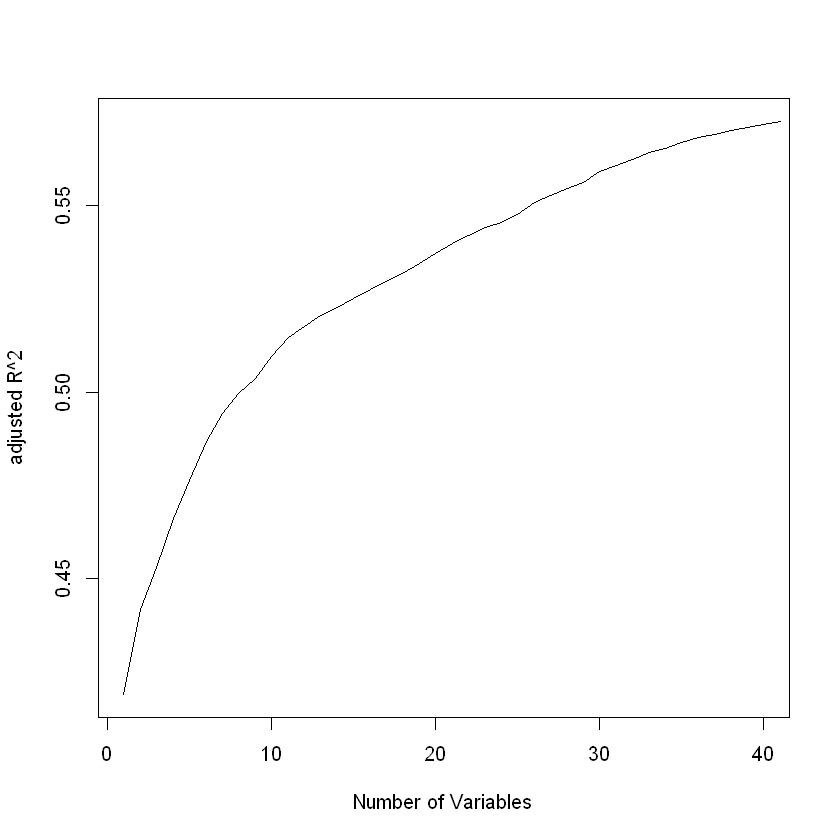

In [81]:
#Foreward selection without cross validation

library(leaps)
nvmax = 40 # Which nmax ? with 40 ~10min to run
reg.fit <- regsubsets(VALENCE.PLEASANTNESS~., data, really.big = T, method = 'forward', nvmax = nvmax) 
regfit.summary <- summary(reg.fit)
summary(reg.fit)$rsq

plot(regfit.summary$adjr2, type = "l", xlim = c(1,nvmax), xlab = "Number of Variables", ylab = "adjusted R^2")
adjr2.max <- which.max(regfit.summary$adjr2)
points(adjr2.max, regfit.fwd.summary$adjr2[adjr2.max], col = "red", cex = 2, pch = 20)

#--> The adjusted R^2 increase with the nb of variables
#--> But : R^2 adjusted is not appropriate in high dimensions : R^2 adjusted = 1 if RSS = 0
#--> Better to mix forward selection with cross validation

In [8]:
#Cross-validation with on each fold foreward selection

#install.packages('tidymodels')
library(leaps)
library(tidymodels)

predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}

evaluate <- function(fold, fit, formula = VALENCE.PLEASANTNESS ~ .) {
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, id, formula))^2))
}
           
validation_data <- vfold_cv(data, v = 5)
fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), method = "forward", nvmax = 30)
    evaluate(fold, fit)
}
           
cv.errors <- sapply(validation_data$splits, fit_and_evaluate)
mean.cv.errors <- rowMeans(cv.errors)
           
#Long à compiler genre env 20-30min
#peut etre à essayer avec d'autre v ou nvmax

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“4553  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“4551  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“4550  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“4545  linear dependencies found”

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“4547  linear dependencies found”

Reordering variables and trying again:


312.9736,358.9913,291.3725,296.2000,324.2709
290.3973,342.6905,286.2468,285.7479,326.3881
289.4018,342.1858,287.7092,299.6378,324.0206
289.1673,341.4138,283.9109,297.1399,317.6771
276.1415,343.5849,280.7474,299.5645,299.9726
279.0484,346.1909,276.6742,304.2180,300.5092
275.4650,341.8703,276.4004,300.0035,295.2009
276.2998,351.8677,286.4637,310.6337,302.4111
269.3002,346.0052,281.5569,312.2530,299.6420
267.7726,346.7616,277.1861,308.8899,302.6627
268.2446,336.2324,273.4581,306.0496,301.6305


[1] 316.7617 306.2941 308.5910 305.8618 300.0022 301.3281 297.7880 305.5352
 [9] 301.7515 300.6546 297.1230 302.3778 301.8641 300.2327 303.9683 303.8391
[17] 305.6677 308.5952 308.3967 309.5191 310.6503 313.1871 315.6535 314.4263
[25] 316.0123 317.3853 319.2848 319.5203 323.5745 324.8821 330.9780

[1] 11

[1] 297.123

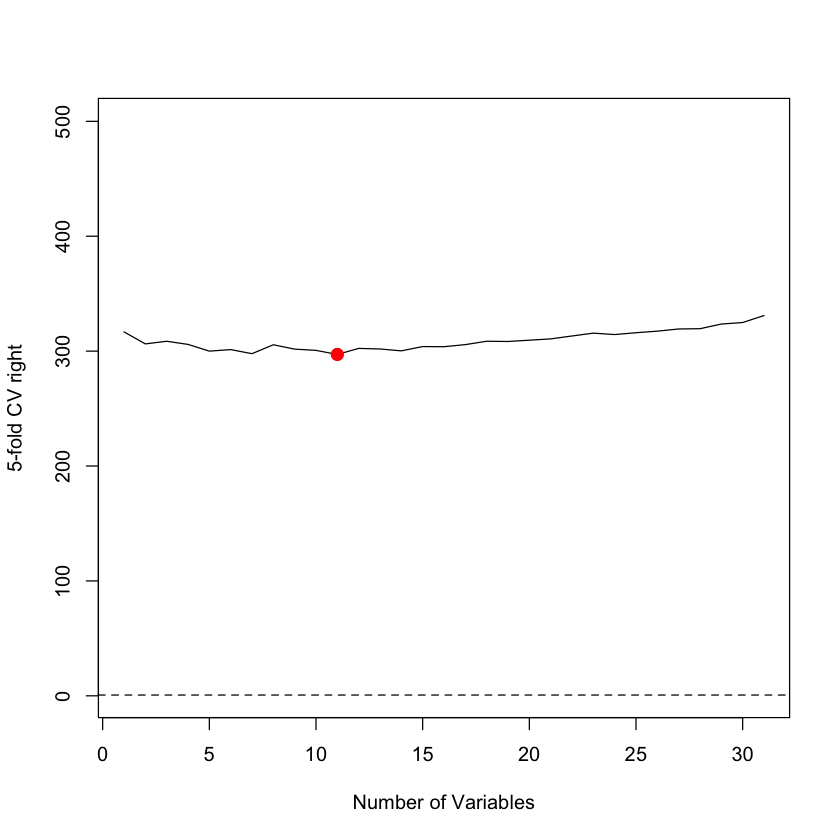

In [11]:
cv.errors
mean.cv.errors           
plot(mean.cv.errors, type = "l", ylim = c(1, 500), xlab = "Number of Variables", ylab = "5-fold CV right")
cv.min = which.min(mean.cv.errors)
cv.min #11
mean.cv.errors[cv.min] #297.123
points(cv.min, mean.cv.errors[cv.min], col = "red", cex = 2, pch = 20)
abline(sd(data$Y), 0, lty = "dashed")

#--> The errors are very high around 300 : the min error = 297 with cv min =11
#--> I think with a higher nvmax it should give a better error but it will take higher amount of time to run 

In [14]:
#data1 <- as.matrix(data_prepared) #--> Je n'arrive pas à changer les data en matrice pour pouvoir utiliser la regularization ??

    #-->Je ne sais pas si c'est la meilleure solution mais glmnet ne gère apparement pas les variables en catégories, il faut donc les remplacer par des dummy variables
    
#filtre sur les données numériques pour ne pas prendre les columnes avec variance 0 et ne pas prendre la réponse, rend le calcul compliqué je ne sais pas si c'est nécessaire
#cols = names(data.dummy[, sapply(data.dummy, function(v) var(v) != 0)]) #eliminate columns woth zero variance

##--> mieux de faire sur data.train? 
#prepare dummy variables
data1x<-data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))]
data1x <- model.matrix(~.-1, data1x)#creates dummy variables
data1y<-data.train$VALENCE.PLEASANTNESS


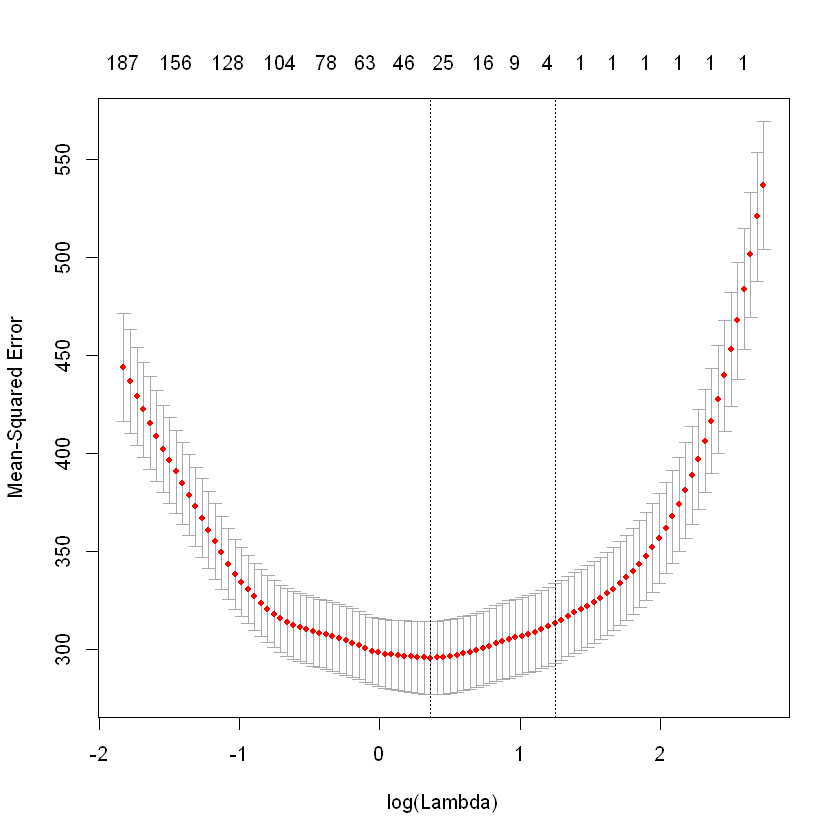

In [40]:
#Cross-validation Lasso
set.seed(12)
#install.packages('glmnet')
library(glmnet)

#cross-validation lasso on training set
cv.lasso <- cv.glmnet(data1x, data1y, alpha = 1)
plot(cv.lasso)
best.lasso <- glmnet(data1x, data1y, alpha = 1, lambda = cv.lasso$lambda.min)
coeffs<-coef(best.lasso)
#best number of predictors is always changing if the seed is not set??

In [41]:
y<-predict(best.lasso,data1x)
RMSE.train=sqrt(mean((y-data1y)**2))
RMSE.train

[1] 15.70239

In [42]:
#prepare test data

data1x.test<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
data1x.test<- model.matrix(~.-1, data1x.test)
data1y.test<-data.test$VALENCE.PLEASANTNESS

#test lasso regularization on test set
y<-predict(best.lasso, data1x.test)
RMSE.test=sqrt(mean((y-data1y.test)**2))

RMSE.test
#still quite high test error

[1] 17.71329

[1] "RMSE for training set: 17.6434069832947"
[1] "RMSE for test set: 21.7619697913163"


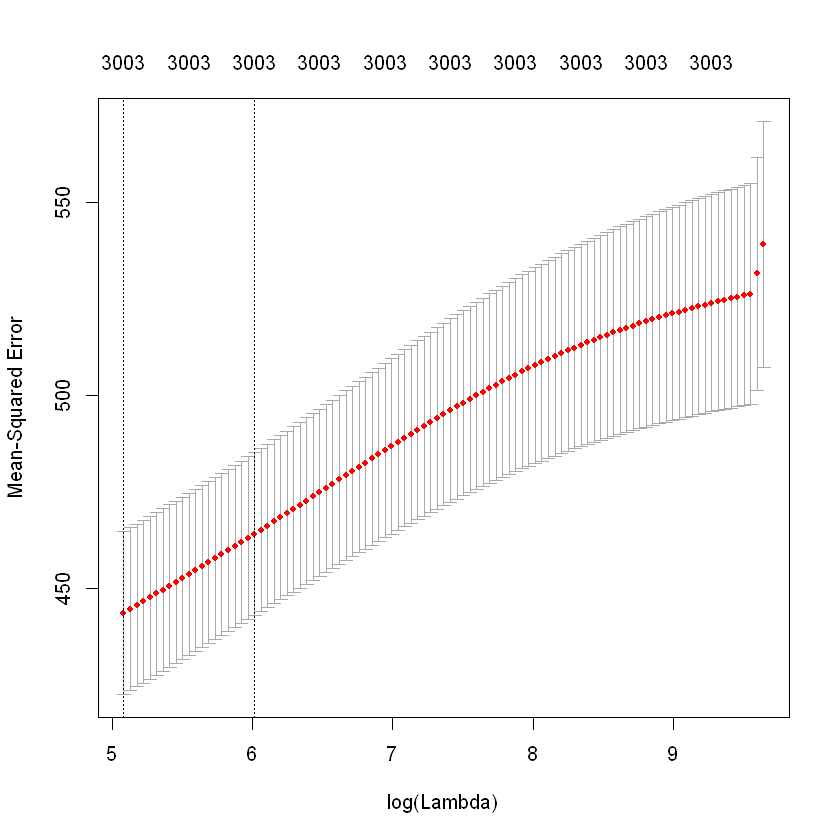

In [38]:
#Same process using Ridge regularization
set.seed(12)

#cross-validation ridge on training set
cv.ridge <- cv.glmnet(data1x, data1y, alpha = 0)
plot(cv.ridge)
best.ridge <- glmnet(data1x, data1y, alpha = 0, lambda = cv.ridge$lambda.min)
coeffs<-coef(best.ridge)

#use model on training data set
y<-predict(best.ridge,data1x)
RMSE.train=sqrt(mean((y-data1y)**2))
print(paste0("RMSE for training set: ",RMSE.train))

#test ridge regularization on test set
y<-predict(best.ridge, data1x.test)
RMSE.test=sqrt(mean((y-data1y.test)**2))

print(paste0("RMSE for test set: ",RMSE.test))

In [27]:
## The results are better with lasso regularization and we will choose lasso regularization with the bootstrap approach.

In [28]:
#The data might have confounder effect, we are going to try using bootstrap data sets

bootstrap<-function(data) data[sample(nrow(data),nrow(data),replace=T),]

fitted.coefficients.lasso <- function(data){
    #prepare data
    datax<-data[,-which(names(data) %in% c("VALENCE.PLEASANTNESS"))]
    datax<- model.matrix(~.-1, datax)
    datay<-data$VALENCE.PLEASANTNESS

    cv.lasso <- cv.glmnet(datax, datay, alpha = 1)
    best.lasso <- glmnet(datax, datay, alpha = 1, lambda = cv.lasso$lambda.min)
    return(coef(best.lasso))
}

#not functionning
summarize <- function(coeffs) {
    m <- Matrix::rowMeans(coeffs)
    B <- ncol(coeffs)
    data.frame(Estimate = m, Std.Error = sqrt(1/(B-1)*rowSums((coeffs - m)^2)))
}
#number of bootstrap data.sets
B=3
#summarize( #je n'ai pas encore réussi à faire une fonction correcte pour summarize..
m<-replicate(B,fitted.coefficients.lasso(bootstrap(data.train)))

In [39]:
beta<-rowMeans(m[[1]][],m[[2]][],m[[3]][]) #permet de visualiser les résultats pour le bootstrap, il faudrait trouver une fonction pour les calculer

bias_input <- function(X) cbind(rep(1, ifelse(is.null(nrow(X)), length(X), nrow(X))), X)

#check before matrix mutliplication
#length(beta) print if you need
#preparation of train set to fit output form
data.train.prep<-bias_input(model.matrix(~.-1, data.train[,-which(names(data.train) %in% c("VALENCE.PLEASANTNESS"))])) #add column of 1 for the intercept


#compute train error
y.pred<-data.train.prep%*%beta
RMSE_bootstrap.train<-sqrt(mean((y.pred-data.train$VALENCE.PLEASANTNESS)**2))
print(paste0("RMSE on the training data with bootstrap: ",RMSE_bootstrap.train))

#compute test error
data.test.prep<-bias_input(model.matrix(~.-1, data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))])) #add column of 1 for the intercept
y.test.pred<-data.test.prep%*%beta
RMSE_bootstrap.train<-sqrt(mean((y.test.pred-data.test$VALENCE.PLEASANTNESS)**2))
print(paste0("RMSE on the test data with lasso regularization and bootstrap: ",RMSE_bootstrap.train))

#résultats légèrement meilleurs que sans bootstrap sur le train set mais pas le test set

[1] "RMSE on the training data with bootstrap: 14.6688208894521"
[1] "RMSE on the test data with lasso regularization and bootstrap: 19.3749227716597"


In [ ]:
#Test with gradient descent (je te laisse mes data préparées si ça t'es utile)

In [3]:
data.train.y<-data.train$VALENCE.PLEASANTNESS
data.train.x<-data.train[,-(which(names(data.train) %in% c("VALENCE.PLEASANTNESS")))]
data.train.x<- as.matrix((model.matrix(~.-1, data.train.x))) #impossible de faire la mulitplication matricielle sinon

#data.test
data.test.x<-data.test[,-which(names(data.test) %in% c("VALENCE.PLEASANTNESS"))]
data.test.x<- as.matrix((model.matrix(~.-1, data.test.x)))
data.test.y<-data.test$VALENCE.PLEASANTNESS


In [4]:
#library(ADtools) can not be installed easily locally on windows, essai avec un algorithm trouvé sur kaggle
